In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
# a library used to draw tree like diagram of how a Value is obatained, not important. 

from graphviz import Digraph

def trace(root):
    # builds a set of all node and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for many value in graph, create a rectangular ('record') node for it 
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.2f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            # if this value is a result of some operation, create an op node for it 
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node for it 
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2 
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)   

    return dot


In [55]:
class Value:
    def __init__(self,data,_children=(),_op = "",label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label=label
        self.grad = 0
        self._backward = lambda:None

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        # other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data,(self,other),_op="+")
        def _backward():
            self.grad += out.grad * 1
        out._backward = _backward    
        return out
    def __radd__(self,other):
        return self + other
        
    def __mul__(self,other):
        # other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data,(self,other),_op="*")
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out
    def __remul__(self,other):
        return self*other

    def backward(self):
        topo = []
        visited = []
        def build_topo(v):
            if v not in visited:
                visited.append(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for i in reversed(topo):
            i._backward()

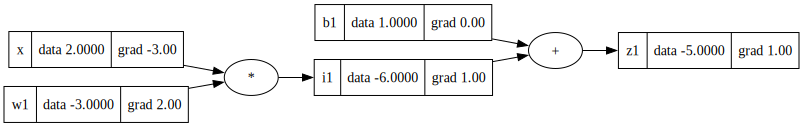

In [60]:
x = Value(2,label='x')
w1 = Value(-3,label='w1')
b1 = Value(1,label='b1')
i1 = x*w1; i1.label = 'i1'
z1 = i1 +b1; z1.label='z1'
z1.backward()
draw_dot(z1)


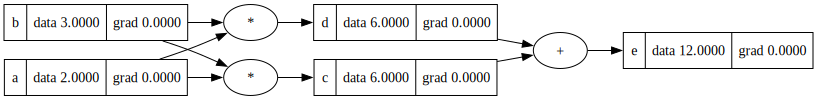

In [58]:
a = Value(2,label='a')
b = Value(3,label='b')
c = a*b; c.label = 'c'
d = a*b ; d.label = 'd'
e = c+d ; e.label = 'e'
draw_dot(e)